# **LSTM for Caption Generation**

Our goal is to implement an LSTM that receives feature vectors as the input and generates captions.

## Setup

In [1]:
import numpy as np
import random
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt

## Datasets
First, we examine the training data:

In [2]:
trData = h5py.File('eee443_project_dataset_train.h5','r')
print([key for key in trData.keys()])

#Captions for training images (contains 17 indices from the vocabulary for each image,note that a single image can have multiple captions provided by different observers)
train_cap = trData['train_cap'][:]
print('\ntrain_cap shape: ', train_cap.shape)
train_size, cap_size = train_cap.shape
tr_size = 10000 #If you don't want to train over the whole the dataset

#The indices of training images (since a single image can be captioned several times, this image index is required to relate each caption with the corresponding image) 
train_imid = trData['train_imid'][:]
print('\ntrain_imid shape: ', train_imid.shape)


#Pretrained feature vector for training images
train_ims = trData['train_ims'][:] 
print('\ntrain_ims shape: ', train_ims.shape)
feature_size = train_ims.shape[1]
feature_min, feature_max = np.min(train_ims), np.max(train_ims)

#dictionary for converting words to vocabulary indices
word_code = trData['word_code'][:]
word_ind = np.array(word_code.tolist())[0,:].astype(int) #Word indices
print('\nMin word index:',np.min(word_ind),', Max word index:',np.max(word_ind))
dictionary_size = len(word_ind)

['train_cap', 'train_imid', 'train_ims', 'train_url', 'word_code']

train_cap shape:  (400135, 17)

train_imid shape:  (400135,)

train_ims shape:  (82783, 512)

Min word index: 0 , Max word index: 1003


Now, we form the training input & target for LSTM:
 - The inputs are the feature vectors;
 - For each input, the target is a sequence of the form $ d[n]\in \mathbb{R}^{1\times|{\rm dictionary}|} $, $n = 0:|{\rm caption}|-1$, where $d[n]$ is the one-hot encoding of the $n$-th word index in the given target caption. 

In [3]:
tr_shuffle = random.sample(range(train_size), tr_size) #for randomly shuffling the training set
X_tr = np.zeros((tr_size, feature_size))
Y_tr = np.zeros((tr_size, cap_size, dictionary_size), dtype = 'int32')
for n in range(tr_size):
    X_tr[n, :] = 2*(train_ims[train_imid[tr_shuffle[n]]-1,:] - feature_min)/(feature_max - feature_min) - 1
    Y_tr[n, range(cap_size), train_cap[tr_shuffle[n],:]] = 1   
print(np.min(X_tr), np.max(X_tr))    

-0.9460400938987732 0.7461137771606445


## Defining & Building the LSTM Network

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Softmax, Dense, LSTM, RepeatVector

sequence_size = cap_size #Lengths of LSTM input & output sequences
n_lstm = 512 #Number of LTSM neurons
initializer = tf.keras.initializers.GlorotUniform() #Xavier initializer

#Building the model for caption generator network
model_capgen = Sequential()
model_capgen.add(RepeatVector(sequence_size))
model_capgen.add(LSTM(n_lstm, return_sequences=True, time_major=False, kernel_initializer=initializer))
model_capgen.add(Dense(n_lstm, activation='tanh', kernel_initializer=initializer))
model_capgen.add(Dense(dictionary_size, kernel_initializer=initializer))
model_capgen.add(Softmax())

#Compile the model
model_capgen.compile( optimizer = 'adam', 
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])


## Training the LSTM Network

In [5]:
batchSize = 64 #Batch size
epochMax = 20 #No. of epochs

#Allow early stoppage based on the validation accuracy
from tensorflow.keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, mode="auto", verbose=1)

history = model_capgen.fit(X_tr,
                           Y_tr,
                           batch_size = batchSize,
                           epochs = epochMax,
                           verbose = 1,
                           validation_split = 0.15,
                           callbacks = [callback])


Train on 8500 samples, validate on 1500 samples
Epoch 1/20
8500/8500 [==============================] - 136s 16ms/sample - loss: 3.4442 - accuracy: 0.3999 - val_loss: 3.1307 - val_accuracy: 0.4384
Epoch 2/20
8500/8500 [==============================] - 142s 17ms/sample - loss: 3.1025 - accuracy: 0.4414 - val_loss: 3.0867 - val_accuracy: 0.4435
Epoch 3/20
8500/8500 [==============================] - 140s 16ms/sample - loss: 3.0785 - accuracy: 0.4421 - val_loss: 3.0885 - val_accuracy: 0.4418
Epoch 4/20
8500/8500 [==============================] - 145s 17ms/sample - loss: 3.0535 - accuracy: 0.4425 - val_loss: 3.0381 - val_accuracy: 0.4471
Epoch 5/20
8500/8500 [==============================] - 150s 18ms/sample - loss: 2.9928 - accuracy: 0.4435 - val_loss: 2.9864 - val_accuracy: 0.4470
Epoch 6/20
8500/8500 [==============================] - 143s 17ms/sample - loss: 2.9466 - accuracy: 0.4454 - val_loss: 2.9577 - val_accuracy: 0.4446
Epoch 00006: early stopping


Let's visualize the training results:

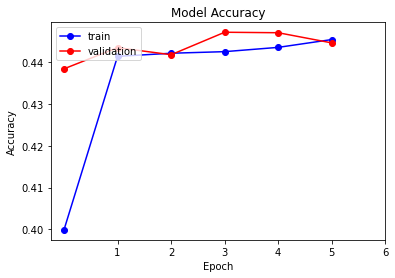

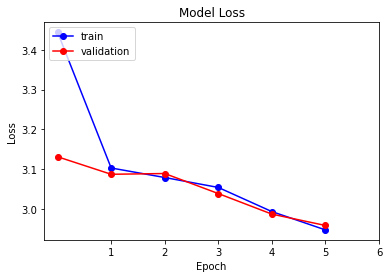

In [6]:
#Accuracy over epochs
plt.plot(history.history['accuracy'], marker = 'o', color = 'blue')
plt.plot(history.history['val_accuracy'], marker = 'o', color = 'red')
plt.xticks(range(1,1+len(history.history['loss'])))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#Loss over epochs
plt.plot(history.history['loss'], marker = 'o', color = 'blue')
plt.plot(history.history['val_loss'], marker = 'o', color = 'red')
plt.xticks(range(1,1+len(history.history['loss'])))
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Testing the LSTM Network

Let's load the test dataset:

In [7]:
tstData = h5py.File('eee443_project_dataset_test.h5','r')
print([key for key in tstData.keys()])

test_cap = tstData['test_caps'][:]
test_imid = tstData['test_imid'][:]
test_ims = tstData['test_ims'][:]

test_size = test_cap.shape[0]
tst_size = 10000 #If you don't want to use the whole dataset
tstf_min, tstf_max = np.min(test_ims), np.max(test_ims)

tst_shuffle = random.sample(range(test_size), tst_size) #for randomly shuffling the test set
X_tst = np.zeros((tst_size, feature_size))
Y_tst = np.zeros((tst_size, cap_size, dictionary_size), dtype = 'int32')
for n in range(tst_size):
    X_tst[n, :] = 2*(test_ims[test_imid[tst_shuffle[n]]-1,:]-tstf_min)/(tstf_max-tstf_min) - 1
    Y_tst[n, range(cap_size), test_cap[tst_shuffle[n],:]] = 1

['test_caps', 'test_imid', 'test_ims', 'test_url']


Now, we evaluate the trained LSTM:

In [8]:
score = model_capgen.evaluate(X_tst,
                              Y_tst,
                              batch_size = 64)

10000/10000 [==============================] - 52s 5ms/sample - loss: 3.4231 - accuracy: 0.4269
